In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkb
import h3
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import transform
import shapely.wkb as swkb
from functools import partial
import pyproj
import matplotlib.pyplot as plt
import rtree
import osmnx as ox
from shapely.ops import unary_union
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 



In [2]:
amsterdam = pd.read_parquet("amsterdam_bike_paths_extended.parquet")
cracow = pd.read_parquet("krakow_bike_paths_extended.parquet")

In [3]:
def extract_features(series):
    dict_of_lists = {}
    for d in series:
        for key, value in d.items():
            dict_of_lists.setdefault(key, []).append(value)
            
    return pd.DataFrame(data=dict_of_lists)

def create_gdf(df):
    df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
    gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
    gdf = gdf.set_crs('EPSG:4326')
    return gdf
gdf_ams = create_gdf(amsterdam)
gdf_krk = create_gdf(cracow)
gdf_ams

id                                               tags  \
0        4264947  {'abandoned:railway': None, 'access': None, 'a...   
1        4270806  {'abandoned:railway': None, 'access': None, 'a...   
2        4305753  {'abandoned:railway': None, 'access': None, 'a...   
3        4363637  {'abandoned:railway': None, 'access': None, 'a...   
4        4364612  {'abandoned:railway': None, 'access': 'yes', '...   
...          ...                                                ...   
8613  1279692697  {'abandoned:railway': None, 'access': None, 'a...   
8614  1279692698  {'abandoned:railway': None, 'access': None, 'a...   
8615  1279692703  {'abandoned:railway': None, 'access': None, 'a...   
8616  1279692704  {'abandoned:railway': None, 'access': None, 'a...   
8617  1280382142  {'abandoned:railway': None, 'access': None, 'a...   

                                               geometry  
0     LINESTRING (4.92236 52.36544, 4.92237 52.36543...  
1     LINESTRING (4.93089 52.36596, 4.93090 52.36585...  
2       LINESTRING (4.86787 52.32198, 4.86787 52.32192)  
3     LINESTRING (4.91538 52.37115, 4.91544 52.37118...  
4     LINESTRING (4.92291 52.37384, 4.92291 52.37389...  
...                                                 ...  
8613  LINESTRING (4.96860 52.37958, 4.96858 52.37956...  
8614  LINESTRING (4.96840 52.37969, 4.96838 52.37968...  
8615  LINESTRING (4.96858 52.37983, 4.96845 52.37992...  
8616    LINESTRING (4.96882 52.37971, 4.96858 52.37983)  
8617  LINESTRING (4.88000 52.34709, 4.88031 52.34687...  

[8618 rows x 3 columns]

Text(492.9494949494949, 0.5, 'Szerokość geograficzna')

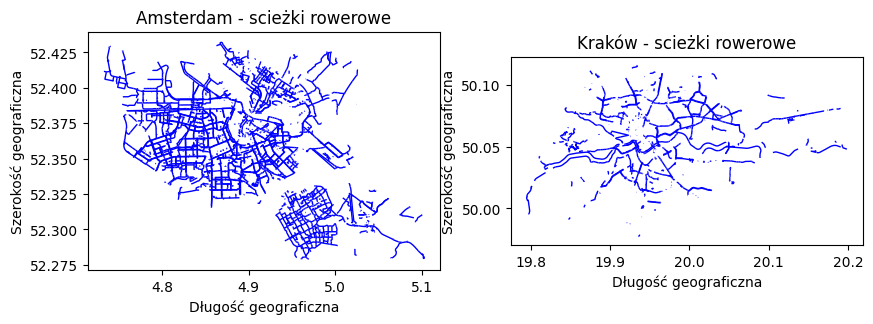

In [4]:
fig, axes = plt.subplots(1,2, figsize = [10, 10])
gdf_ams.plot(ax = axes[0], linewidth = 1, edgecolor = 'blue')

axes[0].set_title('Amsterdam - scieżki rowerowe')
axes[0].set_xlabel('Długość geograficzna')
axes[0].set_ylabel('Szerokość geograficzna')

gdf_krk.plot(ax = axes[1], linewidth = 1, edgecolor = 'blue')

axes[1].set_title('Kraków - scieżki rowerowe')
axes[1].set_xlabel('Długość geograficzna')
axes[1].set_ylabel('Szerokość geograficzna')

In [5]:
# Generowanie heksagonów H3 na obszarze Amsterdamu
def create_h3_hex_grid(df,bounds,epsg=4326):
    resolution = 8  # Rezolucja H3, im wyższa liczba, tym mniejsze heksagony
    buffer = 0.01
    h3_indices = h3.polyfill(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [bounds["west"], bounds["north"]],
                    [bounds["east"], bounds["north"]],
                    [bounds["east"], bounds["south"]],
                    [bounds["west"], bounds["south"]],
                    [bounds["west"], bounds["north"]],
                ]
            ],
        },
        resolution,
    )
    
    # Konwersja H3 do GeoDataFrame
    hexagons = []
    for h in h3_indices:
        hex_boundary = h3.h3_to_geo_boundary(h, geo_json=True)
        hex_boundary = [(lng, lat) for lat, lng in hex_boundary]
        hex_boundary.append(hex_boundary[0])  # Zamknięcie obwodu heksagonu
        hexagons.append({
            'geometry': Polygon(hex_boundary),
            'h3_index': h
        })
    
    gdf_hex = gpd.GeoDataFrame(hexagons)
    gdf_hex = gdf_hex.set_crs(epsg=epsg)
    
    return gdf_hex
 
# Funkcja przypisująca ścieżki rowerowe do heksagonów
def assign_hexagon(geometry, resolution):
    centroid = geometry.centroid
    return h3.geo_to_h3(centroid.y, centroid.x, resolution)



## Siatka hex z mapą

In [6]:
#Współrzędne granic Amsterdamu i Krakowa
amsterdam_bounds = {"north": 52.441157,"south": 52.2688,"east": 5.1127658,"west": 4.728073}
cracow_bounds = {"north":50.1257,"south":49.9639,"east": 20.215,"west":19.7946}

gdf_ams['h3_index'] = gdf_ams['geometry'].apply(assign_hexagon, resolution=8)
gdf_krk['h3_index'] = gdf_krk['geometry'].apply(assign_hexagon, resolution=8)


gdf_krk_hex = create_h3_hex_grid(gdf_krk,cracow_bounds)    
gdf_ams_hex = create_h3_hex_grid(gdf_ams,amsterdam_bounds)    

amsterdam_area = ox.geocode_to_gdf('Amsterdam, Netherlands')
cracow_area = ox.geocode_to_gdf('Kraków')




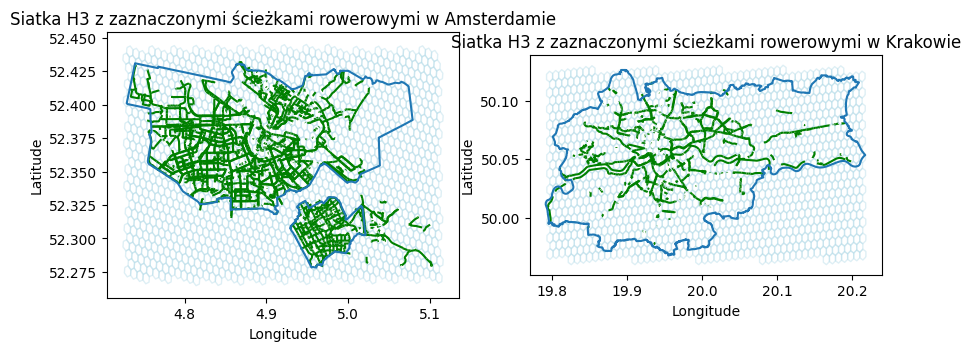

In [7]:
# Wizualizacja
fig, ax = plt.subplots(1,2,figsize=(10, 10))
gdf_ams_hex.plot(ax=ax[0], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_ams.plot(ax=ax[0], color='green')
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ax[0].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk_hex.plot(ax=ax[1], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_krk.plot(ax=ax[1], color='green')
cracow_area['geometry'].boundary.plot(ax=ax[1])

ax[1].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

## Przycięcie map i heksagonów

In [8]:

def crop_hex_grid(gdf_hex,gdf_bike,gdf_area,epsg):
    gdf_bike = gdf_bike.to_crs(epsg=epsg)
    gdf_hex = gdf_hex.to_crs(epsg=epsg)
    gdf_area = gdf_area.to_crs(epsg=epsg)
    gdf_hex['bike_path_length'] = 0.0
    gdf_hex['within_city'] = False

    for i, polygon in gdf_hex.iterrows():
        clipped = gdf_bike.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(gdf_area.geometry)
        gdf_hex.loc[i,'bike_path_length'] = clipped.length.sum()
        gdf_hex.loc[i,'within_city'] = within_city[0]

    gdf_hex = gdf_hex[(gdf_hex['within_city'] == True) | (gdf_hex['bike_path_length'] > 0)]
    gdf_hex = gdf_hex.to_crs(epsg=4326)
    del gdf_hex['within_city']
    
    return gdf_hex

gdf_ams_hex = crop_hex_grid(gdf_ams_hex, gdf_ams, amsterdam_area, 2180)
gdf_krk_hex = crop_hex_grid(gdf_krk_hex, gdf_krk, cracow_area, 2180)


Text(492.9494949494949, 0.5, 'Latitude')

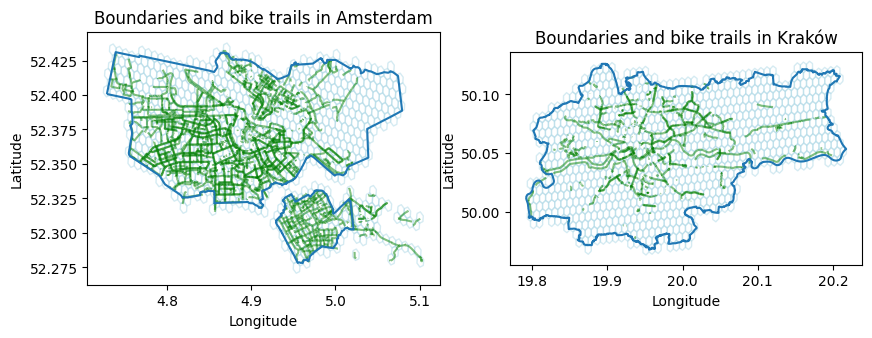

In [9]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
# Set plot title and labels
ax[0].set_title('Boundaries and bike trails in Amsterdam')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
cracow_area['geometry'].boundary.plot(ax=ax[1])
# Set plot title and labels
ax[1].set_title('Boundaries and bike trails in Kraków')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

## Hex razem z policzoną długością ścieżki rowerowej

In [10]:
gdf_ams_hex

geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  
1           700.085343  
4          1498.140837  
6          1410.729241  
8             0.000000  
9          3566.216658  
...                ...  
1384       3019.872511  
1386       1269.119283  
1387       1735.823150  
1388       2374.442108  
1389         98.331034  

[752 rows x 3 columns]

In [11]:
gdf_krk_hex

geometry         h3_index  \
2     POLYGON ((20.21320 50.11129, 20.20918 50.10865...  8852666cabfffff   
3     POLYGON ((20.04804 50.03544, 20.04402 50.03281...  885262c213fffff   
4     POLYGON ((19.89449 50.06419, 19.89046 50.06156...  885262ceedfffff   
5     POLYGON ((20.18498 50.10203, 20.18095 50.09939...  885262d645fffff   
6     POLYGON ((19.93874 50.08853, 19.93472 50.08589...  885262c505fffff   
...                                                 ...              ...   
1210  POLYGON ((20.12037 50.09667, 20.11635 50.09404...  885262d46bfffff   
1214  POLYGON ((19.89087 49.97422, 19.88685 49.97159...  885262cf61fffff   
1215  POLYGON ((20.06836 50.01638, 20.06433 50.01375...  885262c255fffff   
1216  POLYGON ((19.93496 50.03994, 19.93094 50.03731...  885262ce41fffff   
1217  POLYGON ((19.87815 50.10418, 19.87413 50.10155...  885262ce95fffff   

      bike_path_length  
2             0.000000  
3           742.089076  
4           718.985974  
5             0.000000  
6          2439.038184  
...                ...  
1210          0.000000  
1214          0.000000  
1215          0.000000  
1216        283.119357  
1217         76.068542  

[841 rows x 3 columns]

## Pozostałe argumenty 


#### -  długość dróg głównych i chodników



In [12]:
def calculate_road_lengths(amsterdam_bounds, gdf_ams_hex,hex_area):
    # Get road and walk networks
    Ams_roads = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='drive')
    Ams_walks = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='walk')

    # Convert the road network to a GeoDataFrame of edges
    ams_roads = ox.graph_to_gdfs(Ams_roads, nodes=False)
    ams_walks = ox.graph_to_gdfs(Ams_walks, nodes=False)

    # Filter main roads
    ams_roads['highway'] = ams_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
    main_road_types = ['secondary', 'primary', 'tertiary', 'busway', 'motorway_link', 'motorway']
    ams_roads_main = ams_roads[ams_roads['highway'].isin(main_road_types)]

    # Clip to the hexagonal area
    # hex_area = unary_union(gdf_ams_hex.geometry)
    ams_roads_main_clipped = ams_roads_main.geometry.clip(hex_area)
    ams_walks_clipped = ams_walks.geometry.clip(hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_roads_main_clipped_proj = ams_roads_main_clipped.to_crs(epsg=28992)
    ams_walks_clipped_proj = ams_walks_clipped.to_crs(epsg=28992)

    # Initialize length columns
    gdf_ams_hex['main_roads_length'] = 0.0
    gdf_ams_hex['walks_length'] = 0.0

    # Calculate lengths for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_r = ams_roads_main_clipped_proj.clip(polygon.geometry)
        clipped_w = ams_walks_clipped_proj.clip(polygon.geometry)
        gdf_ams_hex.at[i, 'main_roads_length'] = clipped_r.length.sum()
        gdf_ams_hex.at[i, 'walks_length'] = clipped_w.length.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped
    


In [13]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped = calculate_road_lengths(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  main_roads_length  walks_length  
1           700.085343          82.463139  10183.913191  
4          1498.140837        2087.334569  17994.059117  
6          1410.729241        1873.065779  18997.878046  
8             0.000000        1421.611072  18582.541584  
9          3566.216658        5805.158517  18158.018369  
...                ...                ...           ...  
1384       3019.872511         960.759899  23226.060883  
1386       1269.119283        1955.348475   4554.932044  
1387       1735.823150        2902.842643  15650.575909  
1388       2374.442108        2755.485131  26734.803166  
1389         98.331034         311.913775   3613.885648  

[752 rows x 5 columns]

In [14]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_walks_clipped,krk_roads_main_clipped = calculate_road_lengths(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

geometry         h3_index  \
2     POLYGON ((20.21320 50.11129, 20.20918 50.10865...  8852666cabfffff   
3     POLYGON ((20.04804 50.03544, 20.04402 50.03281...  885262c213fffff   
4     POLYGON ((19.89449 50.06419, 19.89046 50.06156...  885262ceedfffff   
5     POLYGON ((20.18498 50.10203, 20.18095 50.09939...  885262d645fffff   
6     POLYGON ((19.93874 50.08853, 19.93472 50.08589...  885262c505fffff   
...                                                 ...              ...   
1210  POLYGON ((20.12037 50.09667, 20.11635 50.09404...  885262d46bfffff   
1214  POLYGON ((19.89087 49.97422, 19.88685 49.97159...  885262cf61fffff   
1215  POLYGON ((20.06836 50.01638, 20.06433 50.01375...  885262c255fffff   
1216  POLYGON ((19.93496 50.03994, 19.93094 50.03731...  885262ce41fffff   
1217  POLYGON ((19.87815 50.10418, 19.87413 50.10155...  885262ce95fffff   

      bike_path_length  main_roads_length  walks_length  
2             0.000000           0.000000   1285.006564  
3           742.089076        3061.588332  28378.066411  
4           718.985974           0.000000  12418.699241  
5             0.000000           0.000000   1817.045247  
6          2439.038184        2061.823344  53794.583416  
...                ...                ...           ...  
1210          0.000000         966.848075   8473.345135  
1214          0.000000         136.428148   8457.630373  
1215          0.000000        1266.615580  13376.758154  
1216        283.119357         348.240700  34518.836461  
1217         76.068542         499.849961   4695.721553  

[841 rows x 5 columns]

#####  Wizualizacja

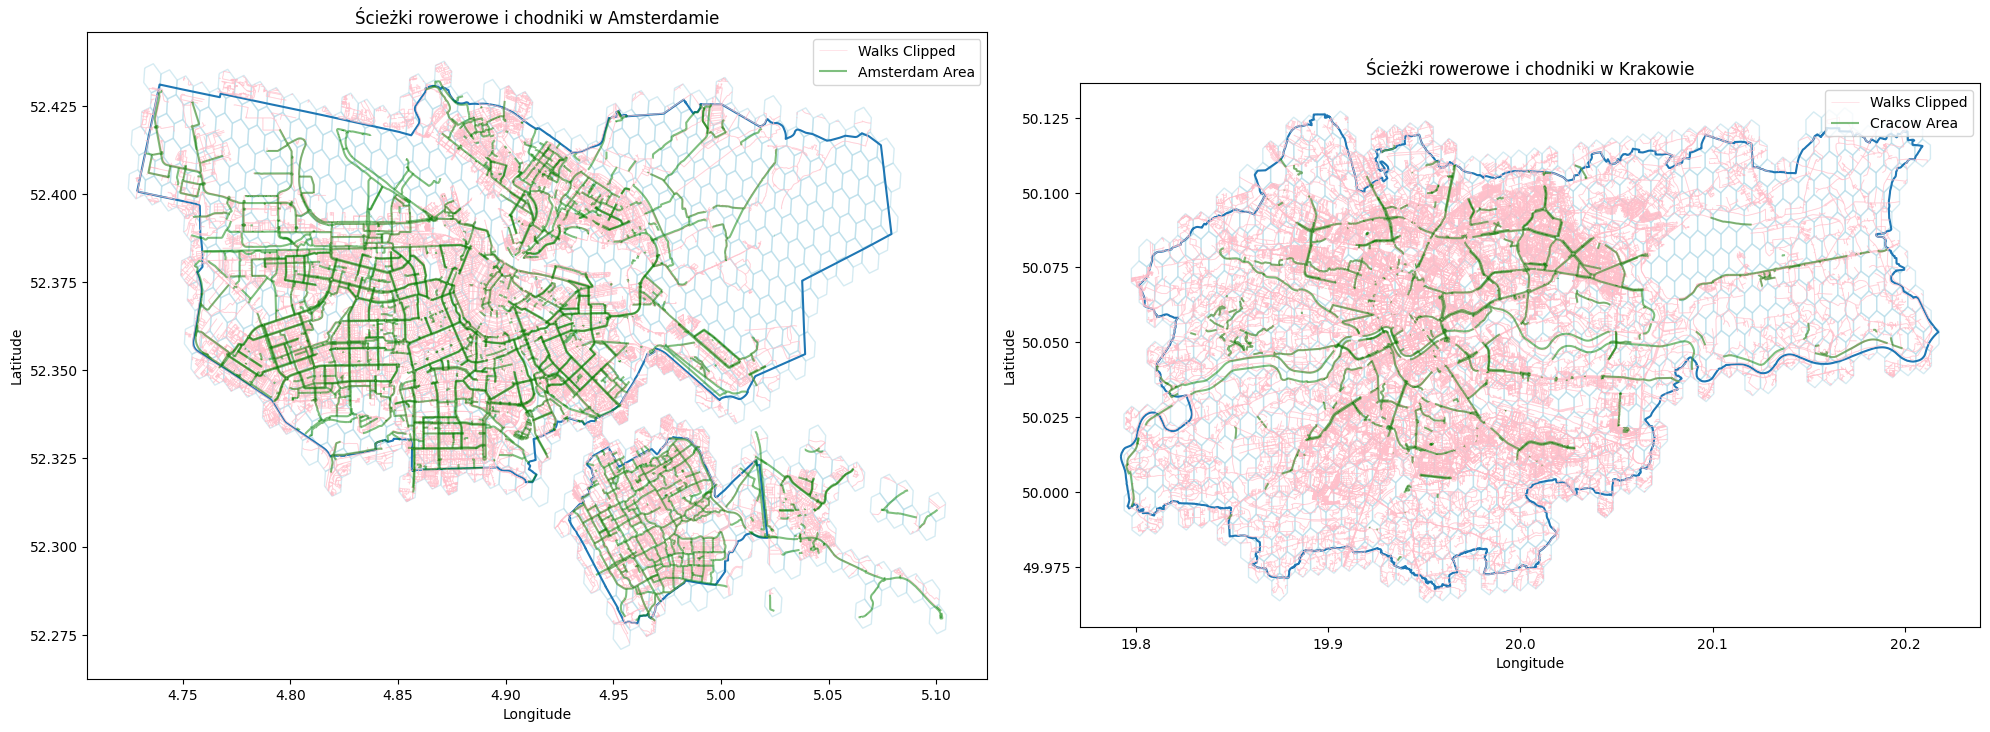

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_walks_clipped.plot(ax=ax[0], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i chodniki w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_walks_clipped.plot(ax=ax[1], edgecolor='pink', facecolor='none', alpha=0.5, linewidth=0.6, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i chodniki w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


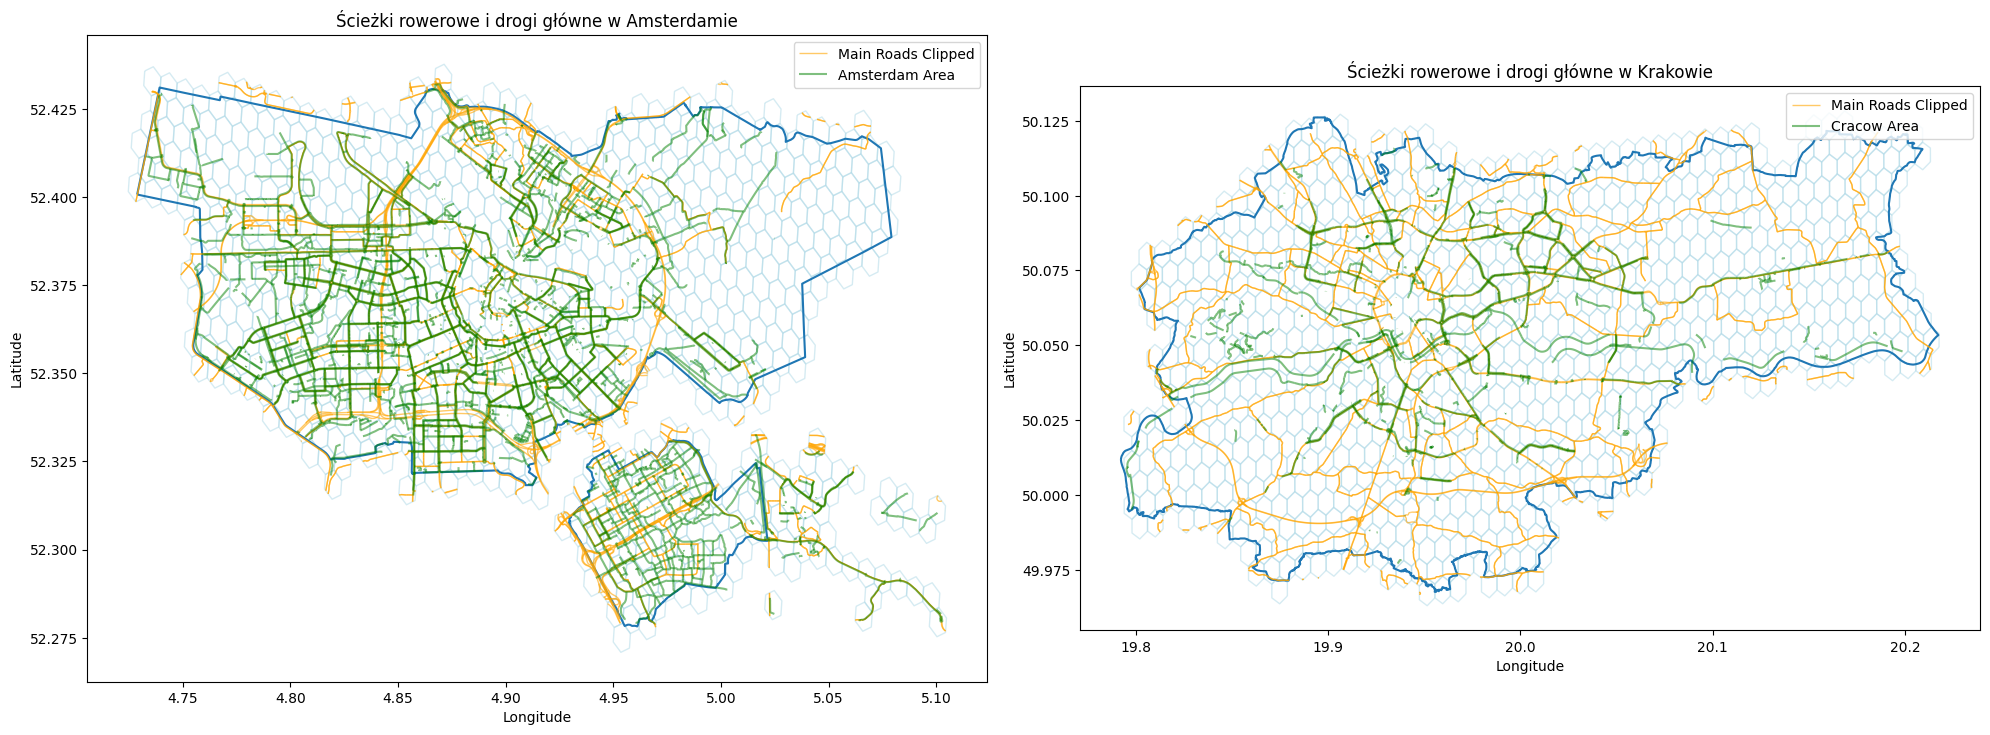

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_roads_main_clipped.plot(ax=ax[0], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_roads_main_clipped.plot(ax=ax[1], edgecolor='orange', facecolor='none', alpha=0.6, linewidth=1, label='Main Roads Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - powierzchnia terenów zielonych

In [17]:
def calculate_green_space_areas(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get green spaces network
    Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                               south=amsterdam_bounds['south'],
                                               east=amsterdam_bounds['east'],
                                               west=amsterdam_bounds['west'],
                                               tags={'leisure': 'park',
                                                     'landuse': ['recreation_ground', 'forest'],
                                                     'natural': 'wood'})

    # Clip to the hexagonal area
    ams_green_spaces_clipped = gpd.clip(Ams_green_spaces, hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_green_spaces_clipped_proj = ams_green_spaces_clipped.to_crs(epsg=28992)

    # Initialize area columns
    gdf_ams_hex['green_space_area'] = 0.0

    # Calculate areas for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_g = gpd.clip(ams_green_spaces_clipped_proj, polygon.geometry)
        gdf_ams_hex.at[i, 'green_space_area'] = clipped_g.area.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex, ams_green_spaces_clipped

In [18]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_green_spaces_clipped = calculate_green_space_areas(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
1           700.085343          82.463139  10183.913191     113440.824892  
4          1498.140837        2087.334569  17994.059117     251063.359327  
6          1410.729241        1873.065779  18997.878046        917.799086  
8             0.000000        1421.611072  18582.541584      30904.067993  
9          3566.216658        5805.158517  18158.018369      23862.100170  
...                ...                ...           ...               ...  
1384       3019.872511         960.759899  23226.060883      18557.857568  
1386       1269.119283        1955.348475   4554.932044      14591.753273  
1387       1735.823150        2902.842643  15650.575909       7176.476353  
1388       2374.442108        2755.485131  26734.803166     271380.513252  
1389         98.331034         311.913775   3613.885648       9490.746178  

[752 rows x 6 columns]

In [19]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_green_spaces_clipped = calculate_green_space_areas(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

/tmp/ipykernel_23524/3490342604.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_green_spaces = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
2     POLYGON ((20.21320 50.11129, 20.20918 50.10865...  8852666cabfffff   
3     POLYGON ((20.04804 50.03544, 20.04402 50.03281...  885262c213fffff   
4     POLYGON ((19.89449 50.06419, 19.89046 50.06156...  885262ceedfffff   
5     POLYGON ((20.18498 50.10203, 20.18095 50.09939...  885262d645fffff   
6     POLYGON ((19.93874 50.08853, 19.93472 50.08589...  885262c505fffff   
...                                                 ...              ...   
1210  POLYGON ((20.12037 50.09667, 20.11635 50.09404...  885262d46bfffff   
1214  POLYGON ((19.89087 49.97422, 19.88685 49.97159...  885262cf61fffff   
1215  POLYGON ((20.06836 50.01638, 20.06433 50.01375...  885262c255fffff   
1216  POLYGON ((19.93496 50.03994, 19.93094 50.03731...  885262ce41fffff   
1217  POLYGON ((19.87815 50.10418, 19.87413 50.10155...  885262ce95fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  
2             0.000000           0.000000   1285.006564       2022.074301  
3           742.089076        3061.588332  28378.066411       4445.505044  
4           718.985974           0.000000  12418.699241      21379.853525  
5             0.000000           0.000000   1817.045247      59313.610738  
6          2439.038184        2061.823344  53794.583416      13093.961294  
...                ...                ...           ...               ...  
1210          0.000000         966.848075   8473.345135       1597.915739  
1214          0.000000         136.428148   8457.630373     105149.969801  
1215          0.000000        1266.615580  13376.758154      52434.029743  
1216        283.119357         348.240700  34518.836461      10344.307794  
1217         76.068542         499.849961   4695.721553     373831.153323  

[841 rows x 6 columns]

/tmp/ipykernel_23524/2189562412.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_23524/2189562412.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


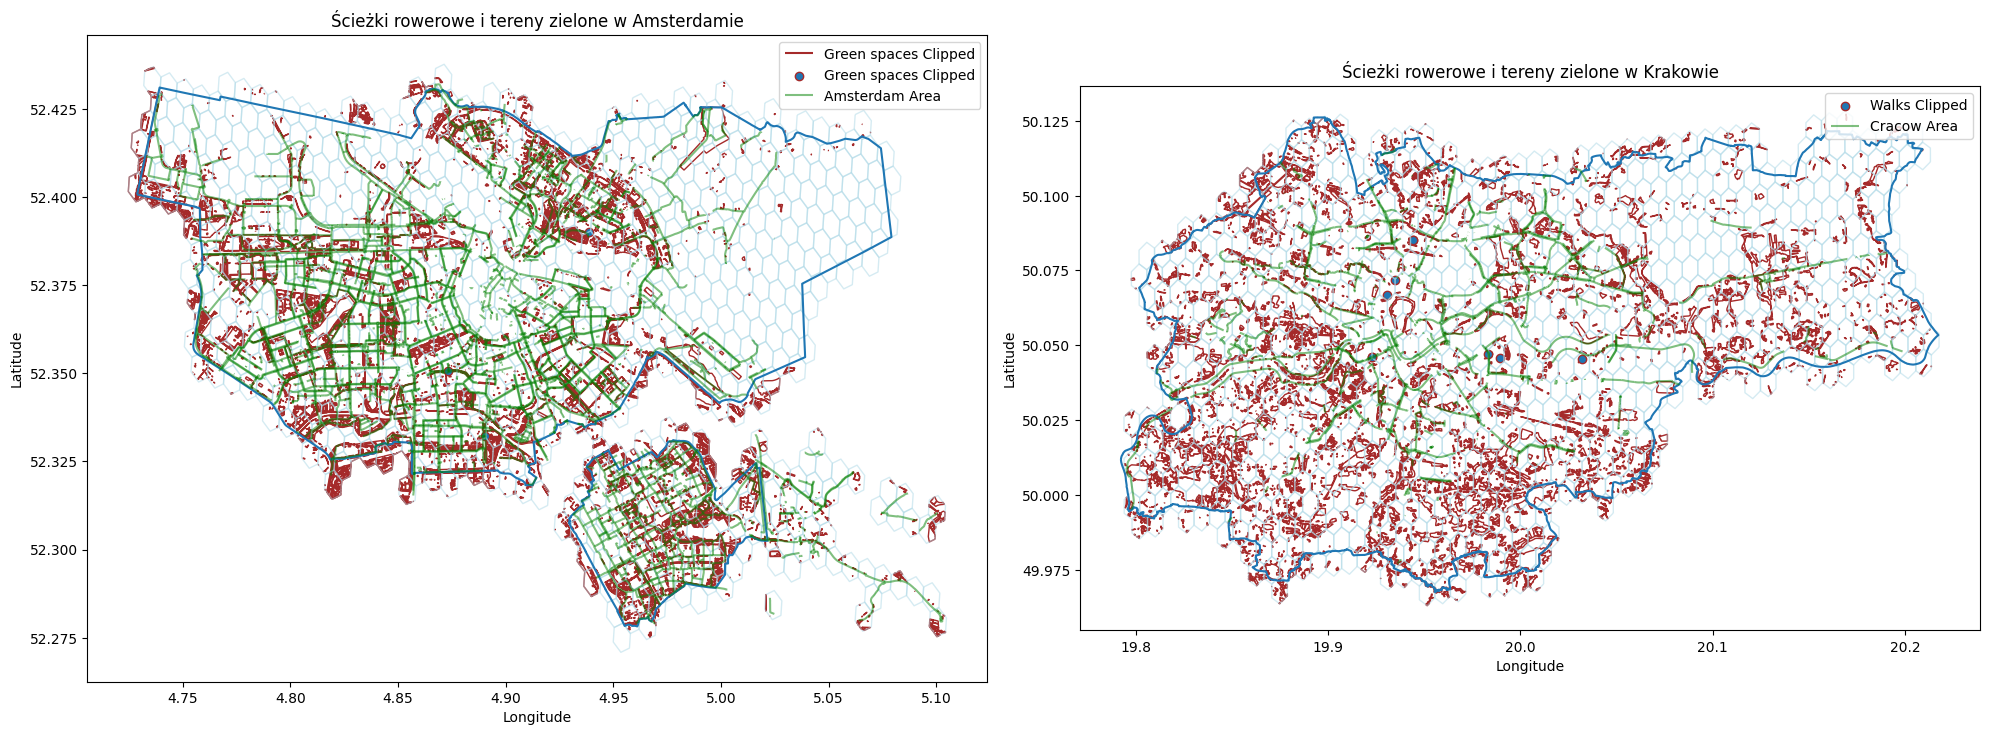

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ams_green_spaces_clipped.plot(ax=ax[0], edgecolor='brown', facecolor='none', alpha=1, label='Green spaces Clipped')
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i tereny zielone w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
krk_green_spaces_clipped.plot(ax=ax[1], edgecolor='brown', facecolor='none', alpha=1, label='Walks Clipped')
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i tereny zielone w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - odległość od centrum miasta

In [21]:
def get_city_center(city_name):
    geolocator = Nominatim(user_agent="city_center_locator")
    location = geolocator.geocode(city_name)
    center_gdf = gpd.GeoDataFrame(geometry=[Point(location.longitude, location.latitude)],crs=4326) 
    if location:
        return center_gdf
    else:
        return None
center_amsterdam = get_city_center("Amsterdam, Netherlands")
center_cracow = get_city_center("Kraków, Poland")
center_amsterdam, center_cracow

(                   geometry
 0  POINT (4.89245 52.37308),
                     geometry
 0  POINT (19.99715 50.04694))

In [22]:
def distance_to_city_center(hex_gdf, center_gdf, epsg=28992):
    old_epsg = hex_gdf.crs.to_epsg()
    center_gdf_proj = center_gdf.to_crs(epsg=epsg)
    hex_gdf = hex_gdf.to_crs(epsg=epsg)
    hex_gdf['distance_to_city_center'] = hex_gdf.geometry.centroid.distance(center_gdf_proj.iloc[0,0])
    hex_gdf = hex_gdf.to_crs(epsg=old_epsg)
    return hex_gdf
    
gdf_ams_hex = distance_to_city_center(gdf_ams_hex, center_amsterdam)
gdf_krk_hex = distance_to_city_center(gdf_krk_hex, center_cracow)

gdf_ams_hex

/home/jupyter-kosta/.local/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/home/jupyter-kosta/.local/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
1           700.085343          82.463139  10183.913191     113440.824892   
4          1498.140837        2087.334569  17994.059117     251063.359327   
6          1410.729241        1873.065779  18997.878046        917.799086   
8             0.000000        1421.611072  18582.541584      30904.067993   
9          3566.216658        5805.158517  18158.018369      23862.100170   
...                ...                ...           ...               ...   
1384       3019.872511         960.759899  23226.060883      18557.857568   
1386       1269.119283        1955.348475   4554.932044      14591.753273   
1387       1735.823150        2902.842643  15650.575909       7176.476353   
1388       2374.442108        2755.485131  26734.803166     271380.513252   
1389         98.331034         311.913775   3613.885648       9490.746178   

      distance_to_city_center  
1                 8205.015231  
4                 4464.826996  
6                 1241.813501  
8                 5870.419408  
9                 3820.002671  
...                       ...  
1384             10546.719950  
1386             10896.480190  
1387              3776.728328  
1388              5057.542899  
1389             10912.011689  

[752 rows x 7 columns]

In [23]:
gdf_krk_hex

geometry         h3_index  \
2     POLYGON ((20.21320 50.11129, 20.20918 50.10865...  8852666cabfffff   
3     POLYGON ((20.04804 50.03544, 20.04402 50.03281...  885262c213fffff   
4     POLYGON ((19.89449 50.06419, 19.89046 50.06156...  885262ceedfffff   
5     POLYGON ((20.18498 50.10203, 20.18095 50.09939...  885262d645fffff   
6     POLYGON ((19.93874 50.08853, 19.93472 50.08589...  885262c505fffff   
...                                                 ...              ...   
1210  POLYGON ((20.12037 50.09667, 20.11635 50.09404...  885262d46bfffff   
1214  POLYGON ((19.89087 49.97422, 19.88685 49.97159...  885262cf61fffff   
1215  POLYGON ((20.06836 50.01638, 20.06433 50.01375...  885262c255fffff   
1216  POLYGON ((19.93496 50.03994, 19.93094 50.03731...  885262ce41fffff   
1217  POLYGON ((19.87815 50.10418, 19.87413 50.10155...  885262ce95fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
2             0.000000           0.000000   1285.006564       2022.074301   
3           742.089076        3061.588332  28378.066411       4445.505044   
4           718.985974           0.000000  12418.699241      21379.853525   
5             0.000000           0.000000   1817.045247      59313.610738   
6          2439.038184        2061.823344  53794.583416      13093.961294   
...                ...                ...           ...               ...   
1210          0.000000         966.848075   8473.345135       1597.915739   
1214          0.000000         136.428148   8457.630373     105149.969801   
1215          0.000000        1266.615580  13376.758154      52434.029743   
1216        283.119357         348.240700  34518.836461      10344.307794   
1217         76.068542         499.849961   4695.721553     373831.153323   

      distance_to_city_center  
2                16985.034547  
3                 3542.435186  
4                 7987.320759  
5                14704.080148  
6                 6635.820214  
...                       ...  
1210             10356.601500  
1214             11231.266333  
1215              5805.811444  
1216              4809.444504  
1217             11069.640341  

[841 rows x 7 columns]

/tmp/ipykernel_23524/3037703094.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_23524/3037703094.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


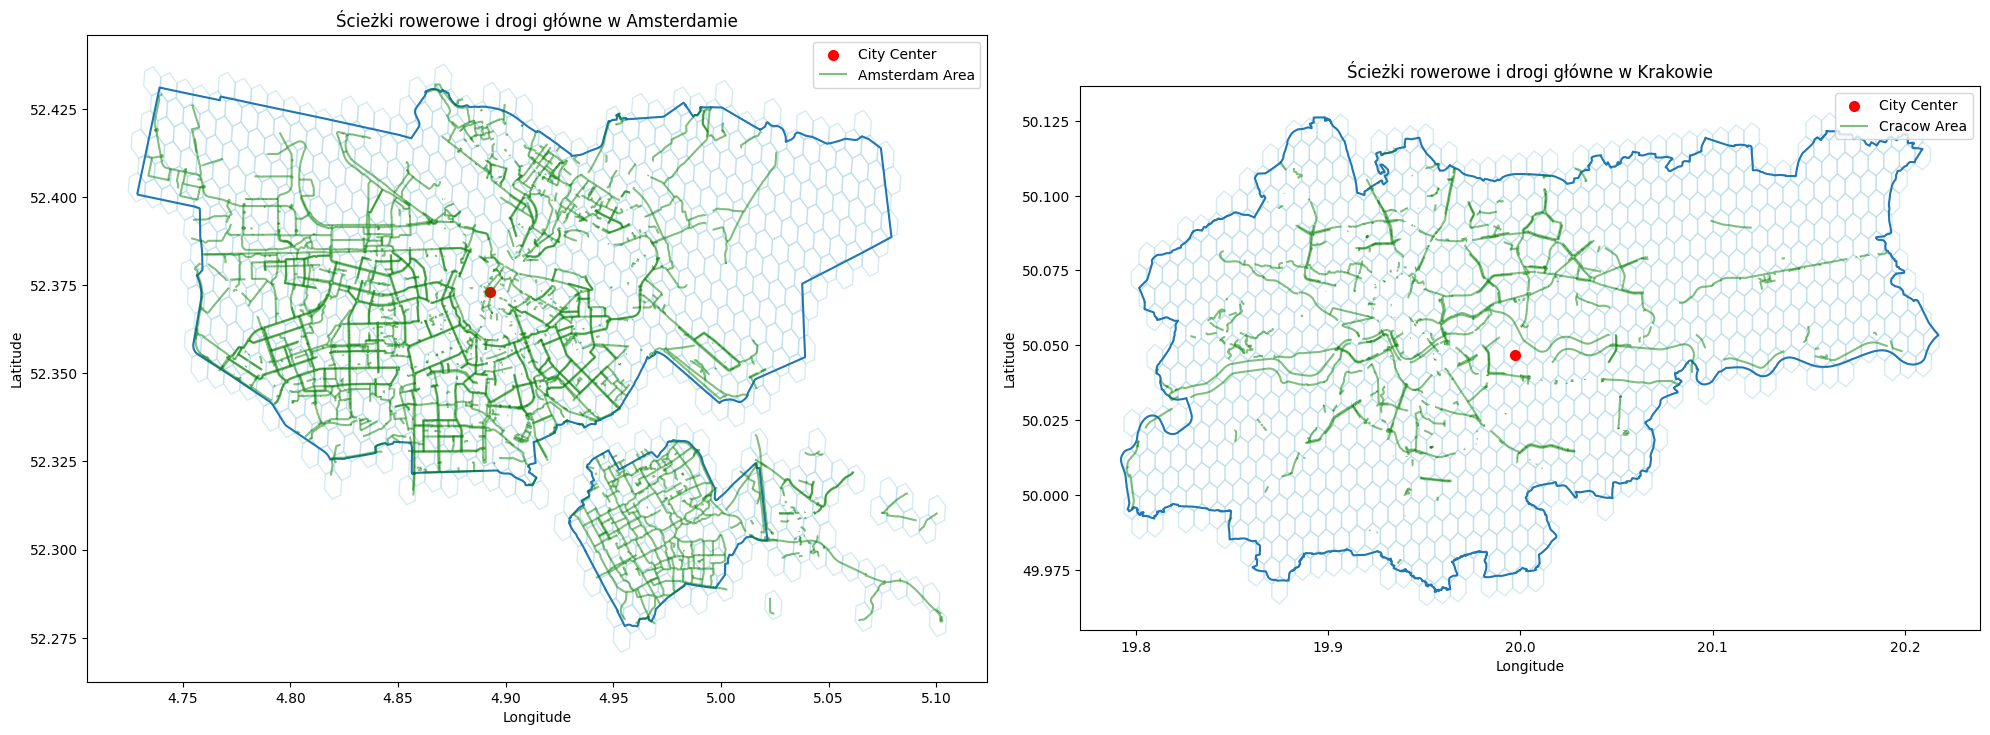

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_amsterdam.plot(ax=ax[0], color="red", linewidth=2, label='City Center')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i drogi główne w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
center_cracow.plot(ax=ax[1], color='red', linewidth=2, label='City Center')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i drogi główne w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


#### - ilość lokali usługowych

In [25]:
def calculate_service_amenities(amsterdam_bounds, gdf_ams_hex, hex_area):
    # Get service amenities
    service_amenity_tags = {
        'amenity': True,  # Includes a variety of amenities like restaurants, cafes, schools, etc.
        'shop': True,     # Includes various types of shops
        'office': True    # Includes office buildings
    }
    
    Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
                                                    south=amsterdam_bounds['south'],
                                                    east=amsterdam_bounds['east'],
                                                    west=amsterdam_bounds['west'],
                                                    tags=service_amenity_tags)

    # Clip to the hexagonal area
    ams_service_amenities_clipped = gpd.clip(Ams_service_amenities, hex_area)

    # Initialize a column for counting amenities
    gdf_ams_hex['service_amenity_count'] = 0

    # Calculate the number of amenities for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_amenities = gpd.clip(ams_service_amenities_clipped, polygon.geometry)
        gdf_ams_hex.at[i, 'service_amenity_count'] = clipped_amenities.shape[0]

    return gdf_ams_hex, ams_service_amenities_clipped

In [26]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_service_amenities_clipped = calculate_service_amenities(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

/tmp/ipykernel_23524/3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
1           700.085343          82.463139  10183.913191     113440.824892   
4          1498.140837        2087.334569  17994.059117     251063.359327   
6          1410.729241        1873.065779  18997.878046        917.799086   
8             0.000000        1421.611072  18582.541584      30904.067993   
9          3566.216658        5805.158517  18158.018369      23862.100170   
...                ...                ...           ...               ...   
1384       3019.872511         960.759899  23226.060883      18557.857568   
1386       1269.119283        1955.348475   4554.932044      14591.753273   
1387       1735.823150        2902.842643  15650.575909       7176.476353   
1388       2374.442108        2755.485131  26734.803166     271380.513252   
1389         98.331034         311.913775   3613.885648       9490.746178   

      distance_to_city_center  service_amenity_count  
1                 8205.015231                     11  
4                 4464.826996                     90  
6                 1241.813501                    100  
8                 5870.419408                     93  
9                 3820.002671                     33  
...                       ...                    ...  
1384             10546.719950                     37  
1386             10896.480190                      1  
1387              3776.728328                    121  
1388              5057.542899                     34  
1389             10912.011689                      1  

[752 rows x 8 columns]

In [27]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_service_amenities_clipped = calculate_service_amenities(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

/tmp/ipykernel_23524/3436094543.py:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  Ams_service_amenities = ox.geometries_from_bbox(north=amsterdam_bounds['north'],
/home/jupyter-kosta/.local/lib/python3.10/site-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)


geometry         h3_index  \
2     POLYGON ((20.21320 50.11129, 20.20918 50.10865...  8852666cabfffff   
3     POLYGON ((20.04804 50.03544, 20.04402 50.03281...  885262c213fffff   
4     POLYGON ((19.89449 50.06419, 19.89046 50.06156...  885262ceedfffff   
5     POLYGON ((20.18498 50.10203, 20.18095 50.09939...  885262d645fffff   
6     POLYGON ((19.93874 50.08853, 19.93472 50.08589...  885262c505fffff   
...                                                 ...              ...   
1210  POLYGON ((20.12037 50.09667, 20.11635 50.09404...  885262d46bfffff   
1214  POLYGON ((19.89087 49.97422, 19.88685 49.97159...  885262cf61fffff   
1215  POLYGON ((20.06836 50.01638, 20.06433 50.01375...  885262c255fffff   
1216  POLYGON ((19.93496 50.03994, 19.93094 50.03731...  885262ce41fffff   
1217  POLYGON ((19.87815 50.10418, 19.87413 50.10155...  885262ce95fffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
2             0.000000           0.000000   1285.006564       2022.074301   
3           742.089076        3061.588332  28378.066411       4445.505044   
4           718.985974           0.000000  12418.699241      21379.853525   
5             0.000000           0.000000   1817.045247      59313.610738   
6          2439.038184        2061.823344  53794.583416      13093.961294   
...                ...                ...           ...               ...   
1210          0.000000         966.848075   8473.345135       1597.915739   
1214          0.000000         136.428148   8457.630373     105149.969801   
1215          0.000000        1266.615580  13376.758154      52434.029743   
1216        283.119357         348.240700  34518.836461      10344.307794   
1217         76.068542         499.849961   4695.721553     373831.153323   

      distance_to_city_center  service_amenity_count  
2                16985.034547                      0  
3                 3542.435186                     18  
4                 7987.320759                     12  
5                14704.080148                      0  
6                 6635.820214                    182  
...                       ...                    ...  
1210             10356.601500                      1  
1214             11231.266333                      0  
1215              5805.811444                     20  
1216              4809.444504                    308  
1217             11069.640341                      6  

[841 rows x 8 columns]

/tmp/ipykernel_23524/2712504861.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[0].legend()
/tmp/ipykernel_23524/2712504861.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[1].legend()


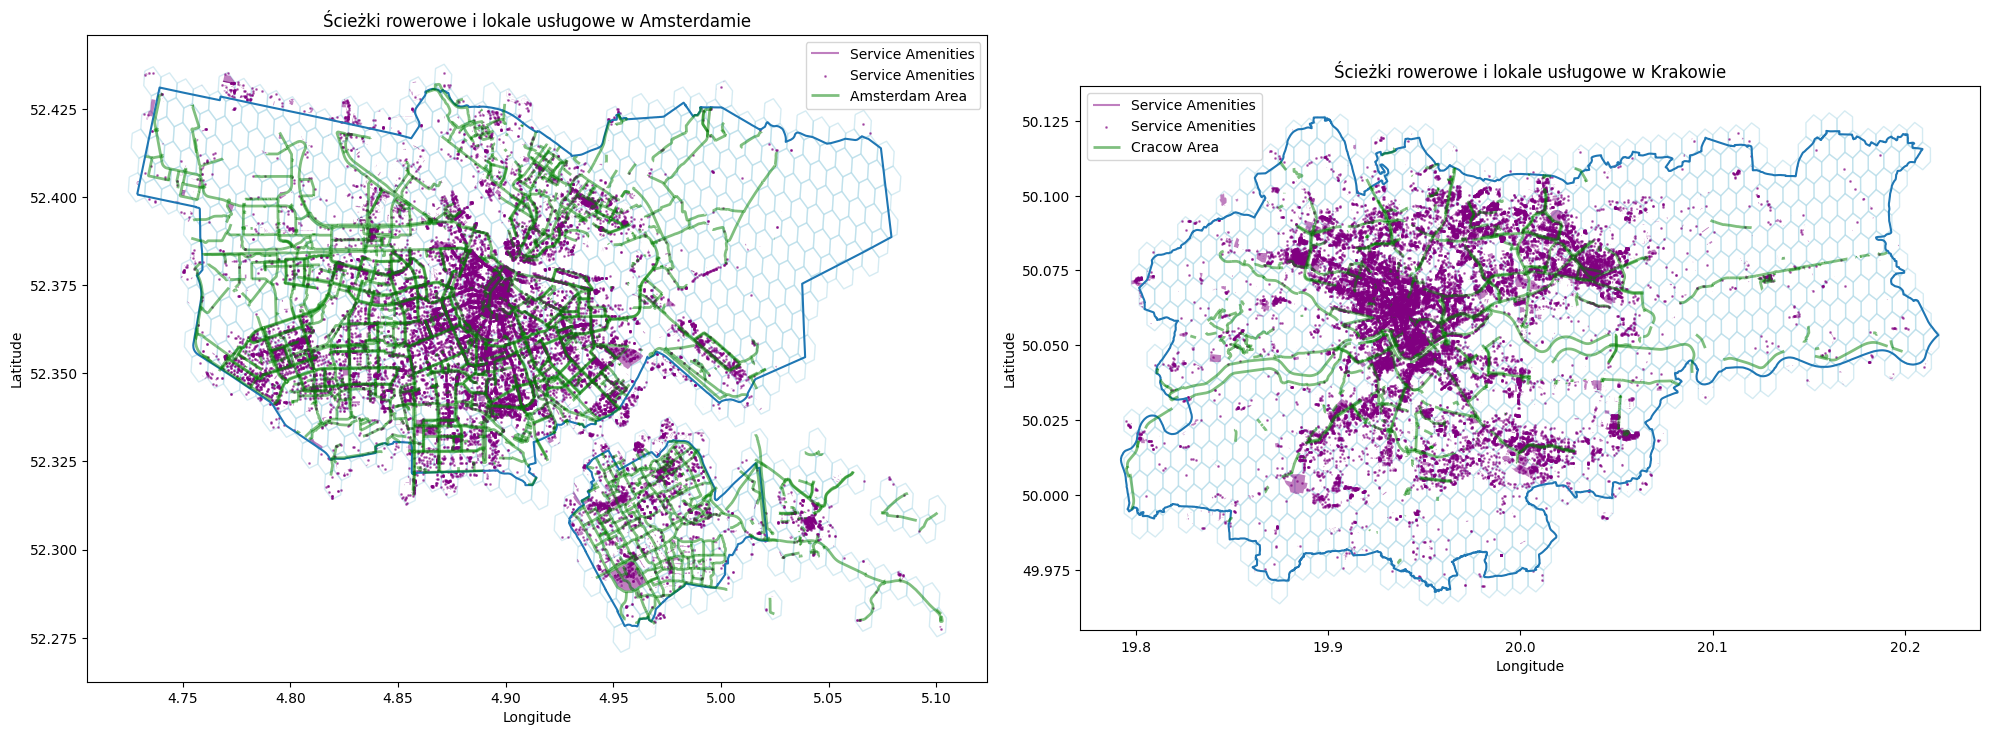

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # Adjusted figsize for better visibility

# Plot Amsterdam
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
ams_service_amenities_clipped.plot(ax=ax[0], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Amsterdam Area')

ax[0].set_title('Ścieżki rowerowe i lokale usługowe w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].legend()

# Plot Kraków
cracow_area['geometry'].boundary.plot(ax=ax[1])
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5, label='Hexagonal Grid')
krk_service_amenities_clipped.plot(ax=ax[1], color='purple', markersize=1, alpha=0.5, label='Service Amenities')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5, linewidth=2, label='Cracow Area')

ax[1].set_title('Ścieżki rowerowe i lokale usługowe w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].legend()

plt.tight_layout()
plt.show()


## Podsumowanie atrybutów

In [43]:
gdf_ams_hex.to_csv('gdf_ams_hex.csv', index=False)
gdf_krk_hex.to_csv('gdf_krk_hex.csv', index=False)

gdf_ams_hex

geometry         h3_index  \
1     POLYGON ((4.76896 52.38294, 4.77295 52.38414, ...  887ab61ac5fffff   
4     POLYGON ((4.89113 52.33590, 4.89512 52.33710, ...  887ab60a03fffff   
6     POLYGON ((4.90712 52.37664, 4.91111 52.37784, ...  887ab60b55fffff   
8     POLYGON ((4.90497 52.42784, 4.90896 52.42904, ...  887ab65687fffff   
9     POLYGON ((4.83942 52.39217, 4.84340 52.39337, ...  887ab61837fffff   
...                                                 ...              ...   
1384  POLYGON ((4.97562 52.29750, 4.97960 52.29870, ...  887ab608adfffff   
1386  POLYGON ((5.02473 52.32430, 5.02871 52.32550, ...  887ab6734dfffff   
1387  POLYGON ((4.85042 52.35158, 4.85441 52.35278, ...  887ab618bdfffff   
1388  POLYGON ((4.88670 52.33057, 4.89068 52.33177, ...  887ab60a1dfffff   
1389  POLYGON ((4.74155 52.41461, 4.74554 52.41581, ...  887ab61a5dfffff   

      bike_path_length  main_roads_length  walks_length  green_space_area  \
1           700.085343          82.463139  10183.913191     113440.824892   
4          1498.140837        2087.334569  17994.059117     251063.359327   
6          1410.729241        1873.065779  18997.878046        917.799086   
8             0.000000        1421.611072  18582.541584      30904.067993   
9          3566.216658        5805.158517  18158.018369      23862.100170   
...                ...                ...           ...               ...   
1384       3019.872511         960.759899  23226.060883      18557.857568   
1386       1269.119283        1955.348475   4554.932044      14591.753273   
1387       1735.823150        2902.842643  15650.575909       7176.476353   
1388       2374.442108        2755.485131  26734.803166     271380.513252   
1389         98.331034         311.913775   3613.885648       9490.746178   

      distance_to_city_center  service_amenity_count  
1                 8205.015231                     11  
4                 4464.826996                     90  
6                 1241.813501                    100  
8                 5870.419408                     93  
9                 3820.002671                     33  
...                       ...                    ...  
1384             10546.719950                     37  
1386             10896.480190                      1  
1387              3776.728328                    121  
1388              5057.542899                     34  
1389             10912.011689                      1  

[752 rows x 8 columns]

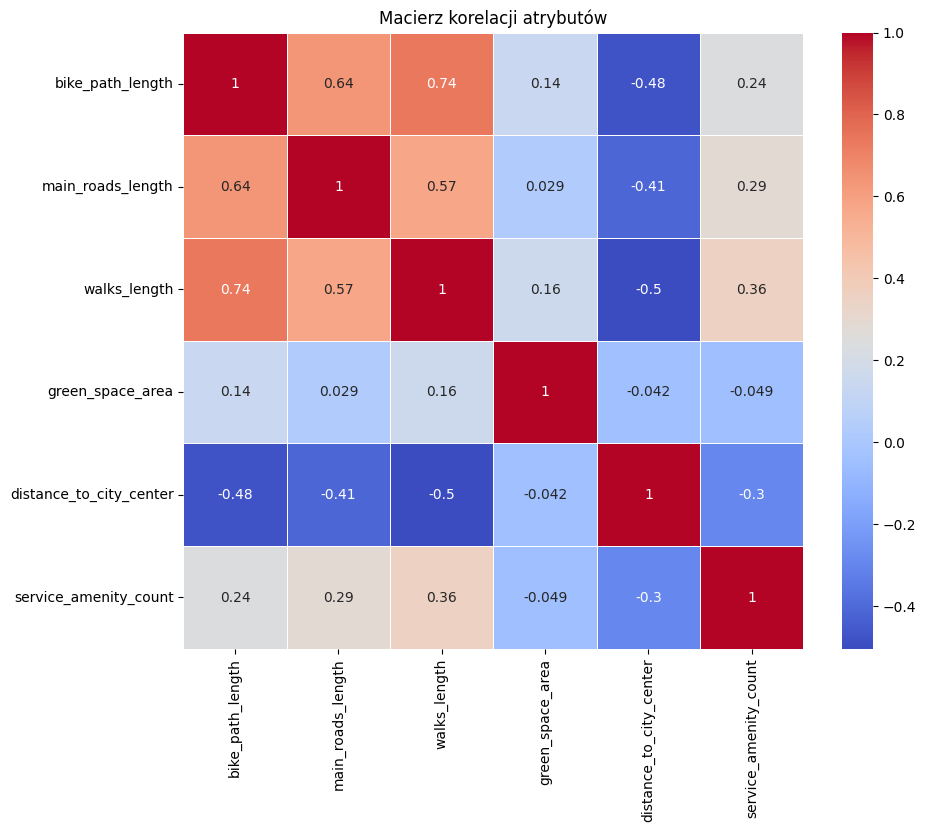

In [30]:
# Obliczanie macierzy korelacji
correlation_matrix = gdf_ams_hex[['bike_path_length','main_roads_length','walks_length','green_space_area','distance_to_city_center','service_amenity_count']].corr()

# Wizualizacja macierzy korelacji za pomocą heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji atrybutów')
plt.show()

## MLFlow

In [40]:
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [44]:
# Split data into features and target variable
X = gdf_ams_hex.drop(['bike_path_length','geometry','h3_index'], axis=1)
y = gdf_ams_hex['bike_path_length']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

